# Import Libraries

In [2]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
#Location of the Image and Content
image = "./images/content.jpg"
style = "./images/style.jpg"

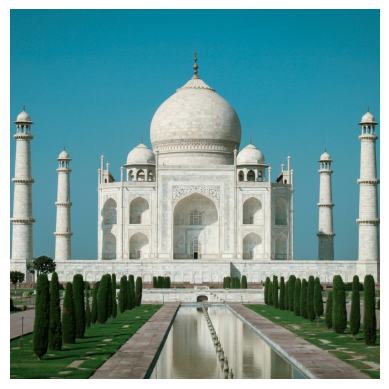

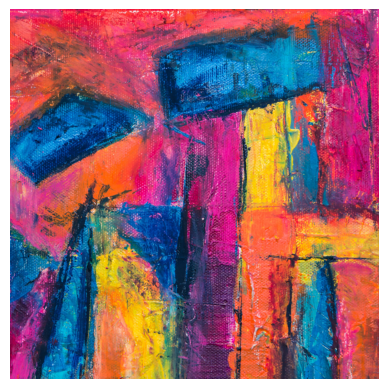

In [3]:
#Function to read jpg image and convert to tensor and also plot the image

def img2tensor(img_path,image_size = 128):

    image = Image.open(img_path)
    plt.figure()
    plt.imshow(image)
    plt.axis("off")

    if max(image.size) <=image_size:
        image_size = max(image.size)

    transform = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size),
                                               torchvision.transforms.ToTensor()])
    img = transform(image).unsqueeze(0)

    return img.to(device, torch.float)

img = img2tensor(image)
styl = img2tensor(style)

# Define Gram Matrix

In [4]:
def gram_matrix(inp):

    """
    This function takes in the input of the batch 

    Output : Normalized Gram Matrix
    """

    num_batch, num_channels, height, width = inp.size()
    feats = inp.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t()) 
    return gram_mat.div(num_batch * num_channels * width * height)
    

# Download the Pretrained Model

In [5]:
vgg19 = torchvision.models.vgg19(weights="IMAGENET1K_V1").to(device)
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
vgg19_model = vgg19.features
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
for param in vgg19_model.parameters():
    param.requires_grad_(False)

# Change the max pool layers to avg pool

In [8]:
conv_indices = []

for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'MaxPool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size, 
                                      stride=vgg19_model[i].stride, 
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)
        
conv_indices = dict(enumerate(conv_indices, 1))
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [9]:
conv_indices

{1: 0,
 2: 2,
 3: 5,
 4: 7,
 5: 10,
 6: 12,
 7: 14,
 8: 16,
 9: 19,
 10: 21,
 11: 23,
 12: 25,
 13: 28,
 14: 30,
 15: 32,
 16: 34}

# Get Relevant Layers

In [11]:
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}
max(layers.keys())

5

In [12]:
vgg_layers = nn.ModuleList(vgg19_model)
last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]
neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


(-0.5, 127.5, 127.5, -0.5)

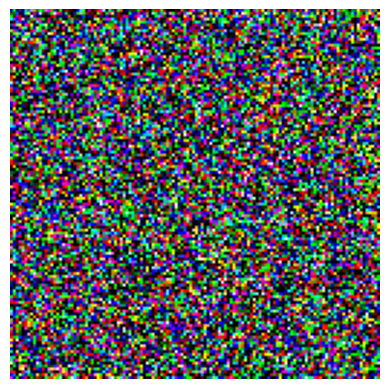

In [13]:
inp_image = torch.randn(img.size()).to(device)
plt.figure()
plt.imshow(inp_image.squeeze(0).permute(1,2,0).cpu().detach().numpy().clip(0,1))
plt.axis('off')

In [14]:
num_epochs=5000
wt_style=1e6
wt_content=1
style_losses = []
content_losses = []
#inp_image = img
img_collection = [] 
opt = optim.Adam([inp_image.requires_grad_()], lr=0.01)

In [15]:
neural_style_transfer_model[:conv_indices[4]+1]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [16]:
neural_style_transfer_model[:conv_indices[3]+1](styl).size()

torch.Size([1, 128, 64, 64])

In [17]:
for curr_epoch in range(1, num_epochs+1):
    
    inp_image.data.clamp_(0, 1)
    opt.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0

    for k in layers.keys():
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k]+1](img).detach()
            ip = neural_style_transfer_model[:conv_indices[k]+1](inp_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        if 's' in layers[k]:
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](styl)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](inp_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()
    
    if curr_epoch % 100 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")
        #plt.figure()
        #plt.title(f"epoch number {curr_epoch}")
        #plt.imshow(inp_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
        #plt.show()
        img_collection.append(inp_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
        style_losses += [epoch_style_loss.cpu().detach().numpy()]
        content_losses += [epoch_content_loss.cpu().detach().numpy()]

    opt.step()

epoch number 100
style loss = 10.857412338256836, content loss = 6.2729644775390625
epoch number 200
style loss = 4.877864837646484, content loss = 5.3280816078186035
epoch number 300
style loss = 3.0178685188293457, content loss = 4.511875152587891
epoch number 400
style loss = 2.141932249069214, content loss = 3.90891432762146
epoch number 500
style loss = 1.6530929803848267, content loss = 3.488738775253296
epoch number 600
style loss = 1.3347007036209106, content loss = 3.1985273361206055
epoch number 700
style loss = 1.1015355587005615, content loss = 2.9945130348205566
epoch number 800
style loss = 0.9293060898780823, content loss = 2.8452320098876953
epoch number 900
style loss = 0.8014814257621765, content loss = 2.729311943054199
epoch number 1000
style loss = 0.7048483490943909, content loss = 2.6411094665527344
epoch number 1100
style loss = 0.6326520442962646, content loss = 2.570201873779297
epoch number 1200
style loss = 0.5770148038864136, content loss = 2.51272892951965

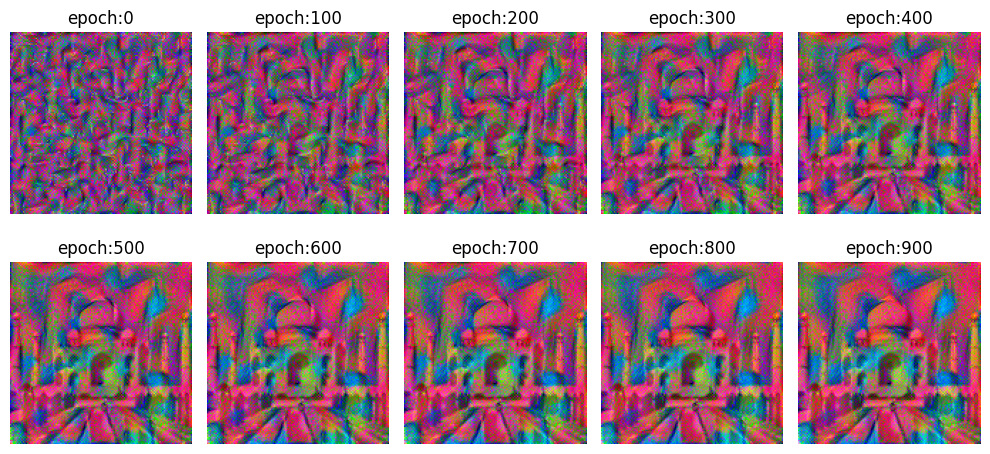

<Figure size 640x480 with 0 Axes>

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(10, 8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(img_collection[i])
    ax.set_title(f"epoch:{i*100}")
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.75])  # Leave space for the main title
plt.show()
plt.savefig('./results/random_wtstyl1e5_wecnt1.png')

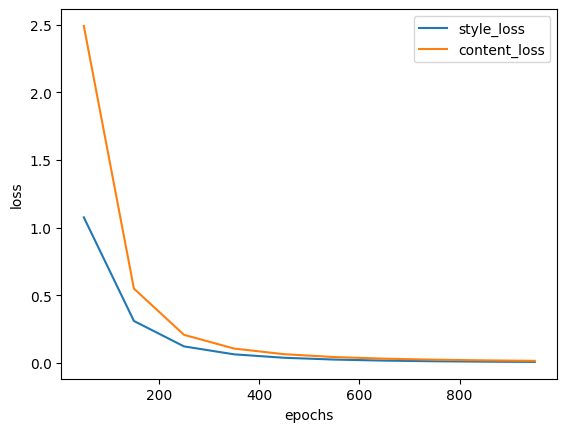

In [171]:
plt.plot(range(50, num_epochs+1, 100), style_losses, label='style_loss');
plt.plot(range(50, num_epochs+1, 100), content_losses, label='content_loss');
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

plt.savefig('./results/random_image_wtstyl1e5_wecnt1_loss.png')